In [1]:
# Python
from datetime import datetime
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore') 

# Thrid part
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('seaborn') # ggplot
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format
import re
from scipy import stats
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set_theme(style="darkgrid")

# Time series
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from fbprophet import Prophet
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, ARMA

# Support modules
from support import HelperFunc as HF
from support.HelperFunc import add_value_labels
from support import DeepLearnFunc as DL

In [2]:
# Parameters

FILEPATH = './data/Backup_orders_after_preparation.csv'

TODAY = datetime.today()
DATE_START_HISTORY = (2017,1,1)
DATE_END_HISTORY = (TODAY.year,TODAY.month,TODAY.day)

TEST_SIZE = 3 # MONTHS

# For out of sample forecasts 
PERIODS = 6 # MONTHS

In [3]:
# Load orders file
try:
    df = HF.load_orders(FILEPATH)
except Exception as e:
    print(e)

# Obtain the time series using the support function - RESAMPLED MONTHS
timeseries = HF.make_pivot_orders_channel(
                    df
                    , period = 'M'
                    , date_start = DATE_START_HISTORY
                    , date_end = DATE_END_HISTORY
                    , roll = 12
                    ).Total

timeseries.shape

(54,)

In [4]:
# Make train and test sets

y = timeseries.values
X = timeseries.index.values

X_train = X[:-TEST_SIZE]
X_test = X[-TEST_SIZE:]
y_train = y[:-TEST_SIZE]
y_test = y[-TEST_SIZE:]

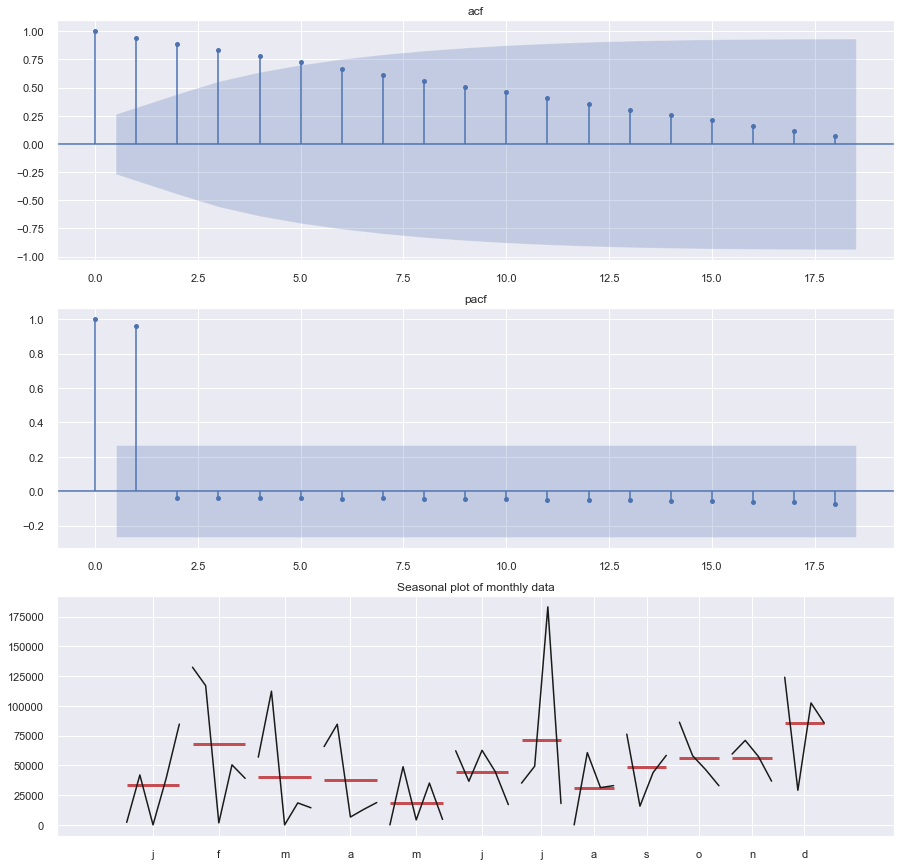

In [10]:
# Plot ACF and PACF to find ARMA coeffs for the estimated residuals

fig, axs = plt.subplots(3,1, figsize=(15,15))
plot_acf(X, title='acf', ax = axs[0])
plot_pacf(X, title='pacf', ax = axs[1])
month_plot(timeseries, ax = axs[2]) # timeseries
axs[2].set_title('Seasonal plot of monthly data')
plt.show()

In [11]:
# ARMA autoregressive model of 2nd order

pqs = [(2,0), (2,1),(2,2)]
mse = []

for pq in pqs:
    model_arma = ARMA(y_train, pq).fit(trend='nc', disp=0)
    preds_arma = model_arma.forecast(len(y_test))
    mse.append(((y_test-preds_arma[1])**2).sum()/len(y_test))

mse_df = pd.DataFrame({'pqs': pqs, 'mse': mse})

display(mse_df.set_index('pqs').style.format('{:,e}'))

# Fit the model
model_arma = ARMA(y_train, mse_df.loc[mse_df.mse.idxmin(axis=0), 'pqs']).fit(trend='nc', disp=0) 

# Predict
preds_arma = model_arma.forecast(len(y_test))

print('mse: {:.6}'.format(MSE(y_test, preds_arma[1])))

,mse
pqs,
"(2, 0)",1.214048e+09
"(2, 1)",6.834230e+08
"(2, 2)",2.345307e+09


mse: 6.83423e+08


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Total   No. Observations:                   54
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 3)   Log Likelihood                -614.179
Date:                             Thu, 15 Jul 2021   AIC                           1238.359
Time:                                     16:00:17   BIC                           1248.018
Sample:                                 01-31-2017   HQIC                          1242.050
                                      - 06-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -636.8139   1876.464     -0.339      0.734   -4314.616    3040.988
ar.L1          0.2437      0.233      1.048      0.295      -0.212       0.700
ar.L2          0.0662      0.237      0.279      0.780      -0.398       0.531
ma.S.L3       -0.9175      0.382     -2.400      0.016      -1.667      -0.168
sigma2       2.25e+09      0.003   7.56e+11      0.000    2.25e+09    2.25e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                18.10
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             1.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+27. Standard errors may be unstable.
"""

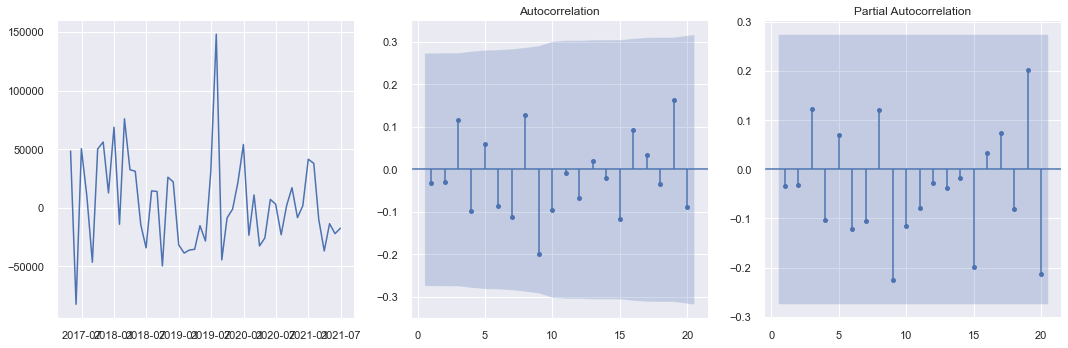

In [12]:
# SARIMA

SARIMA_PERIODICITY = 3 # MONTHS

# Plot autocorrelation and partial autocorrelation functions
def plots(data, lags=None):
    plt.figure()
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

# Fit the model
sar = sm.tsa.statespace.SARIMAX(timeseries, 
                                order=(2,0,0), 
                                seasonal_order=(0,1,1,SARIMA_PERIODICITY), 
                                trend='c').fit()
display(sar.summary())

# Plot summary statistics for the residual curve
plots(sar.resid[sar.loglikelihood_burn:], lags=20);

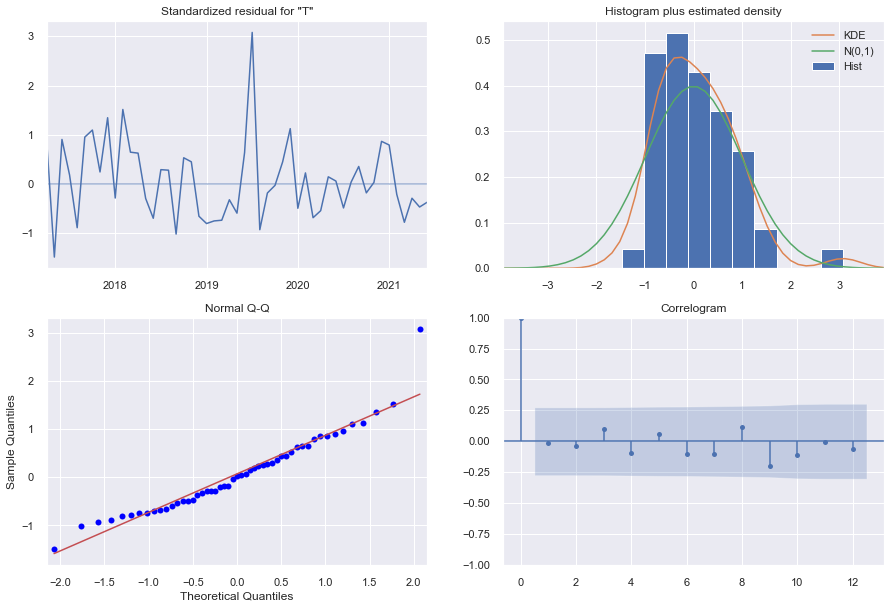

In [13]:
# Plot diagnostocs which show the normality and no autocorrelation
sar.plot_diagnostics(lags=12,figsize = (15,10));

In [14]:
# Predict SARIMA
preds_sarima = sar.predict(start = 1, end= len(X_test))

print('mse: {:.6}'.format(MSE(y_test, preds_sarima)))

mse: 2.77195e+08


In [15]:
# create and run other statistical tests on SARIMA model

# Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]

# Null hypothesis is no serial correlation in residuals (independent of each other)
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]

# Tests for change in variance between residuals. The null hypothesis is no heteroskedasticity
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

lb_val = lb_val[-1]
lb_p = lb_p[-1]

# Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=18.104, p=0.000
Ljung-Box: val=1.951, p=0.924
Heteroskedasticity: val=0.296, p=0.016
Durbin-Watson: d=1.98


In [16]:
# Autofit model - optimize 

SARIMA_SEASONALITY = 3 # MONTHS

auto_model = pm.auto_arima(timeseries
                               , start_p=0
                               , d=1
                               , start_q=0
                               , max_p=5
                               , max_d=5
                               , max_q=5
                               , start_P=0
                               , D=1
                               , start_Q=0
                               , max_P=5
                               , max_D=5
                               , max_Q=5
                               , m=SARIMA_SEASONALITY
                               , seasonal=True
                               , trace=True
                               , error_action='ignore'
                               , suppress_warnings=True
                               , stepwise=True)
print(auto_model.aic())

auto_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=1255.323, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=1240.884, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=1224.291, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=1239.961, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[3]             : AIC=1226.266, Time=0.07 sec
 ARIMA(0,1,1)(0,1,2)[3]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[3]             : AIC=1233.966, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[3]             : AIC=1228.272, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=1227.907, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[3]             : AIC=1225.280, Time=0.04 sec
 ARIMA(0,1,2)(0,1,1)[3]             : AIC=1225.762, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[3]             : AIC=1227.526, Time=0.03 sec
 ARIMA(1,1,2)(0,1,1)[3]             : AIC=1227.681, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[3] intercept   : AIC=1225.551, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,1,1)[3]  

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 3),
      suppress_warnings=True, with_intercept=False)

In [17]:
# Fit the optimized model
sar_optimized = sm.tsa.statespace.SARIMAX(timeseries, 
                                order=auto_model.order, 
                                seasonal_order=auto_model.seasonal_order, 
                                trend='c').fit()

display(sar_optimized.summary());

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Total   No. Observations:                   54
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 3)   Log Likelihood                -608.775
Date:                           Thu, 15 Jul 2021   AIC                           1225.551
Time:                                   16:00:25   BIC                           1233.199
Sample:                               01-31-2017   HQIC                          1228.463
                                    - 06-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -472.9154   1079.435     -0.438      0.661   -2588.570    1642.739
ma.L1         -0.6620      0.278     -2.385      0.017      -1.206      -0.118
ma.S.L3       -0.9004      0.320     -2.817      0.005      -1.527      -0.274
sigma2      3.287e+09      0.000   1.08e+13      0.000    3.29e+09    3.29e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                40.62
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             1.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.41e+29. Standard errors may be unstable.
"""

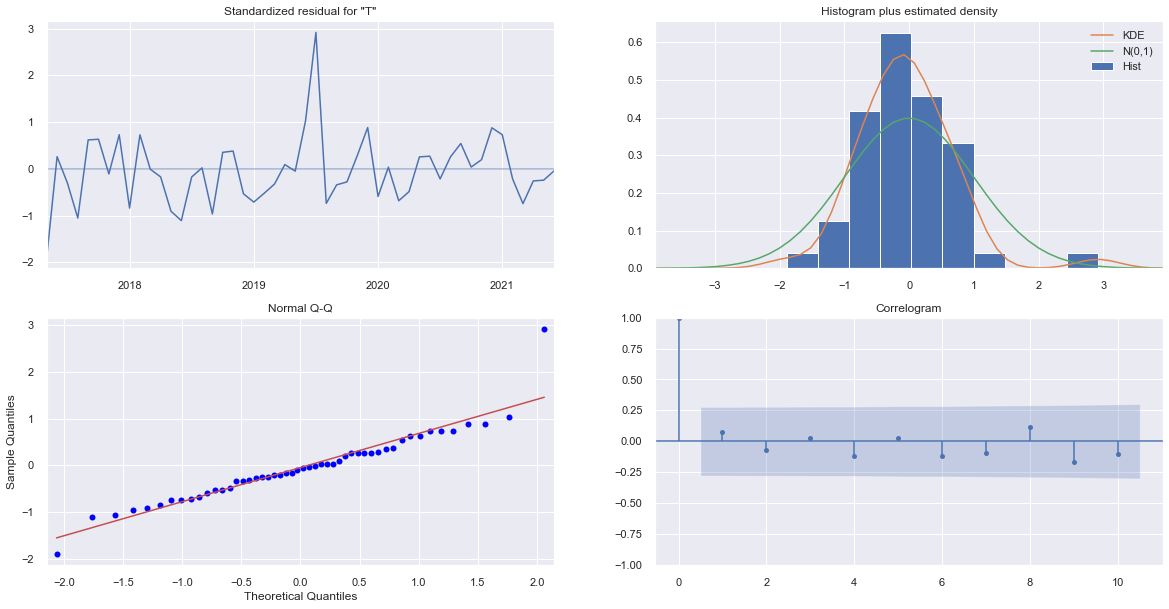

In [18]:
# Plot diagnostocs which show the normality and no autocorrelation
sar_optimized.plot_diagnostics(figsize = (20,10));

In [19]:
# Predict with optimized SARIMA
preds_sarima_optimized = sar_optimized.predict(start = 1, end= len(X_test))

print('mse: {:.6}'.format(MSE(y_test, preds_sarima_optimized)))

mse: 2.4238e+09


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


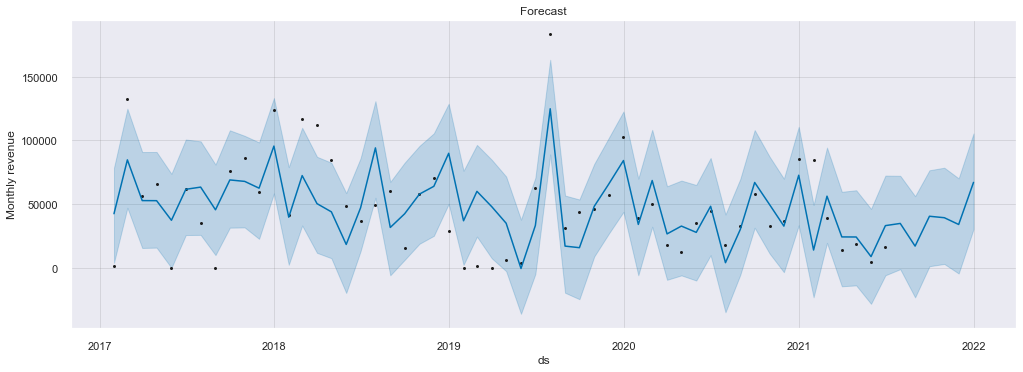

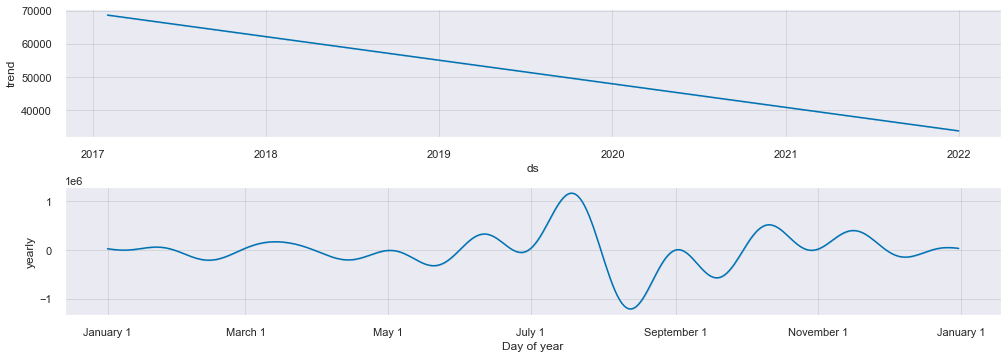

In [20]:
# FB Prophet

# Re-organize the time series for Prophet
prophet_df = pd.DataFrame({'ds': X, 'y': y})

# create the object
m = Prophet()

# Fit the model
m.fit(prophet_df)

# Create the time series for prediction using Prophet make_future_dataframe
future = m.make_future_dataframe(periods=PERIODS, freq='M')

# Predict
forecast_prohpet = m.predict(future)

# Plot forecast and the components
fig1 = m.plot(forecast_prohpet)
fig1.set_size_inches(15,5)
ax = fig1.gca()
ax.set(ylabel='Monthly revenue', title='Forecast')

fig2 = m.plot_components(forecast_prohpet)
fig2.set_size_inches(15,5)

plt.show()

In [22]:
print('mse: {:.6}'.format(MSE(y_test, forecast_prohpet.set_index('ds').loc[timeseries.index[-TEST_SIZE:], 'yhat'])))

mse: 1.06666e+08


In [5]:
# Deep Learning RNN and LSTM

# Create the dataframe
df_timeseries = pd.DataFrame(timeseries)

# Scale the data
scaler = MinMaxScaler()
scaler.fit(df_timeseries)
df_scaled = pd.DataFrame(np.reshape(scaler.transform(df_timeseries), (-1,)), columns=['Total'], index=df_timeseries.index)

# Define parameters which the support functions use to create the train and test splits
SERIES_PERIODS = timeseries.shape[0]
INPUT_PERIODS = 6
TEST_PERIODS = 12
SAMPLE_GAP = 1

# Train and test split scaled for training and predicting
X_train_dl_sc, X_test_dl_init_sc, y_train_dl_sc, y_test_dl_sc = DL.get_train_test_data(df_scaled, 'Total', SERIES_PERIODS, INPUT_PERIODS, TEST_PERIODS, SAMPLE_GAP)

print('Training input shape: {}'.format(X_train_dl_sc.shape))
print('Training output shape: {}'.format(y_train_dl_sc.shape))
print('Test input shape: {}'.format(X_test_dl_init_sc.shape))
print('Test output shape: {}'.format(y_test_dl_sc.shape))

Training input shape: (36, 6, 1)
Training output shape: (36,)
Test input shape: (6,)
Test output shape: (6,)


In [24]:
# Fit a simple RNN
history, model1 = DL.fit_SimpleRNN(X_train_dl_sc, y_train_dl_sc, cell_units=70, epochs=1500)

display(model1.summary())

# Predict with RNN
preds_rnn_sc = DL.predict(X_test_dl_init_sc, n_steps=len(y_test_dl_sc), model=model1)

# Inverse scaling
y_test_dl = scaler.inverse_transform(np.reshape(y_test_dl_sc,(-1,1)))
preds_rnn = scaler.inverse_transform(preds_rnn_sc)

print('mse: {:.6}'.format(MSE(y_test_dl, preds_rnn)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 70)                5040      
_________________________________________________________________
activation (Activation)      (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 5,111
Trainable params: 5,111
Non-trainable params: 0
_________________________________________________________________


None

mse: 1.47593e+08


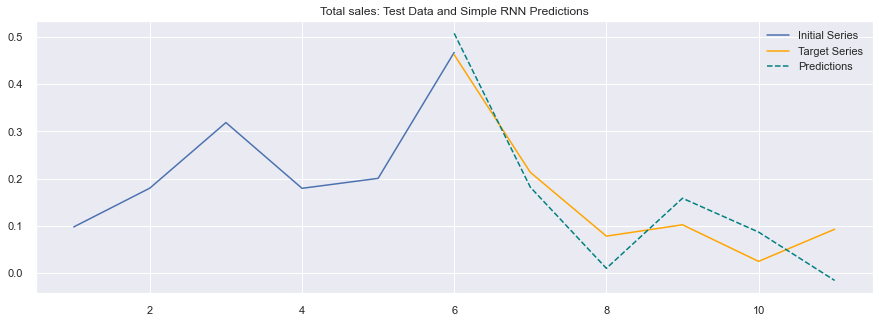

In [25]:
# Plot the prediction vs the train and test data
plt.figure()
DL.predict_and_plot(X_test_dl_init_sc, y_test_dl_sc, model1,
                 'Total sales: Test Data and Simple RNN Predictions', TEST_PERIODS)

In [26]:
# Create and fit a LSTM using the support function
history, model2 = DL.fit_LSTM(X_train_dl_sc, y_train_dl_sc, cell_units=70, epochs=1500) 

model2.summary()

preds_lstm_sc = DL.predict(X_test_dl_init_sc, n_steps=len(y_test_dl_sc), model=model2)
preds_lstm = scaler.inverse_transform(preds_lstm_sc)

print('mse: {:.6}'.format(MSE(y_test_dl, preds_lstm)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20160     
_________________________________________________________________
activation_1 (Activation)    (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
mse: 1.32157e+09


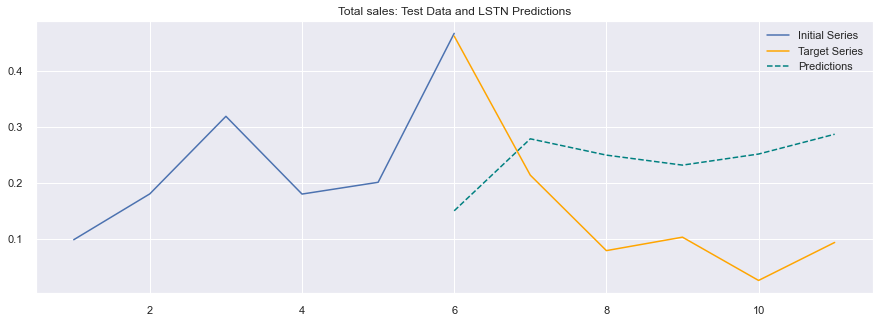

In [27]:
# Plot the prediction vs the train and test data

plt.figure()
DL.predict_and_plot(X_test_dl_init_sc, y_test_dl_sc, model2,
                 'Total sales: Test Data and LSTN Predictions', TEST_PERIODS)

In [28]:
# Create and fit a stacked LSTM (with 2 LSTM layers) using the support function
history, model3 = DL.fit_LSTM_stacked(X_train_dl_sc, y_train_dl_sc, cell_units=70, epochs=1500) 

model3.summary()

preds_lstm_sc = DL.predict(X_test_dl_init_sc, n_steps=len(y_test_dl_sc), model=model3)
preds_lstm = scaler.inverse_transform(preds_lstm_sc)

print('mse: {:.6}'.format(MSE(y_test_dl, preds_lstm)))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 70)             20160     
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 71        
Total params: 59,711
Trainable params: 59,711
Non-trainable params: 0
_________________________________________________________________
mse: 1.88206e+09


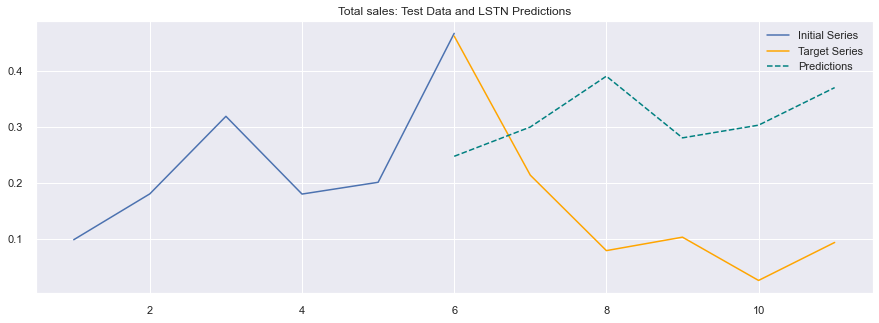

In [29]:
# Plot the prediction vs the train and test data
plt.figure()
DL.predict_and_plot(X_test_dl_init_sc, y_test_dl_sc, model3,
                 'Total sales: Test Data and LSTN Predictions', TEST_PERIODS)

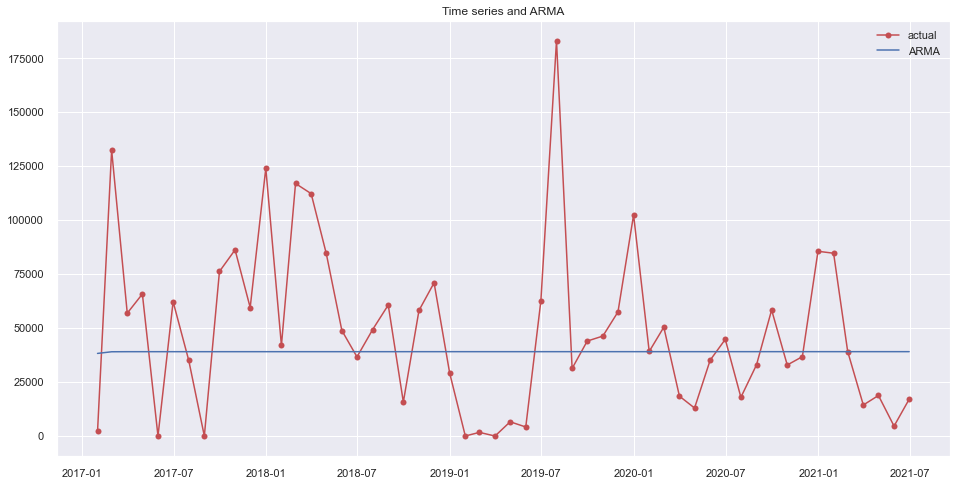

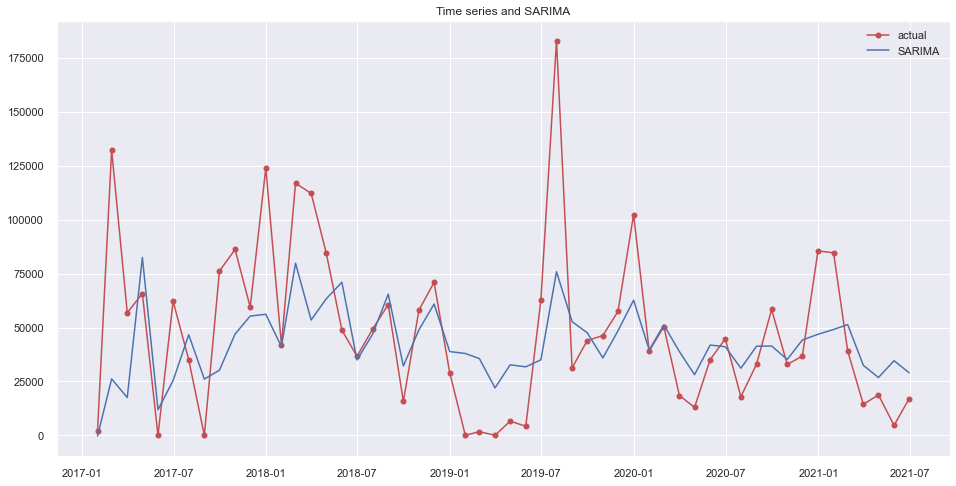

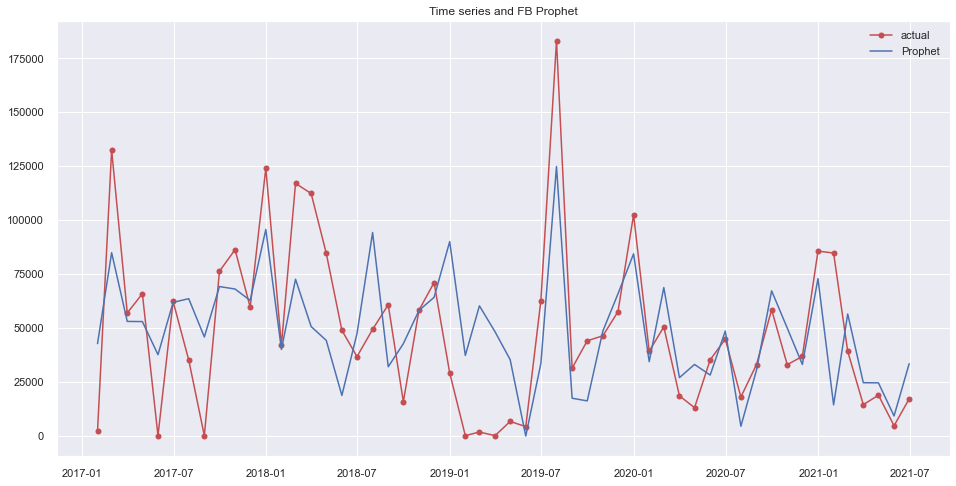

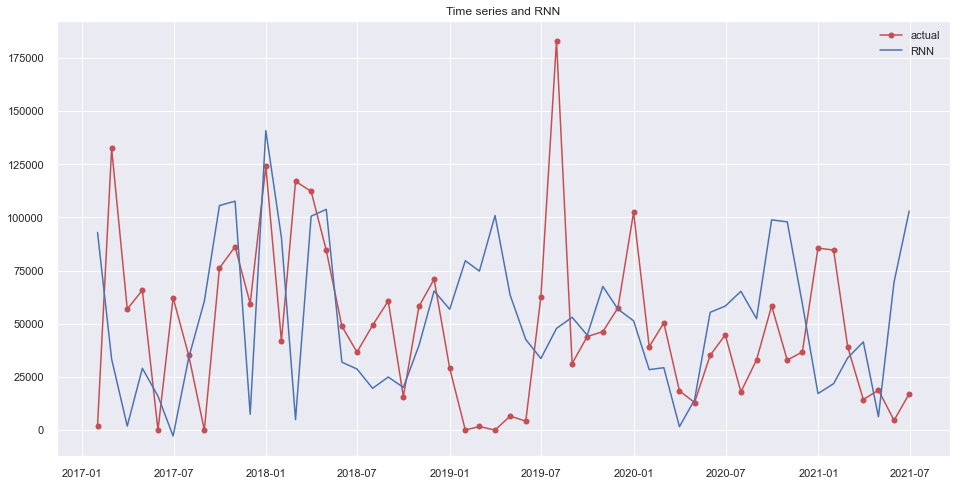

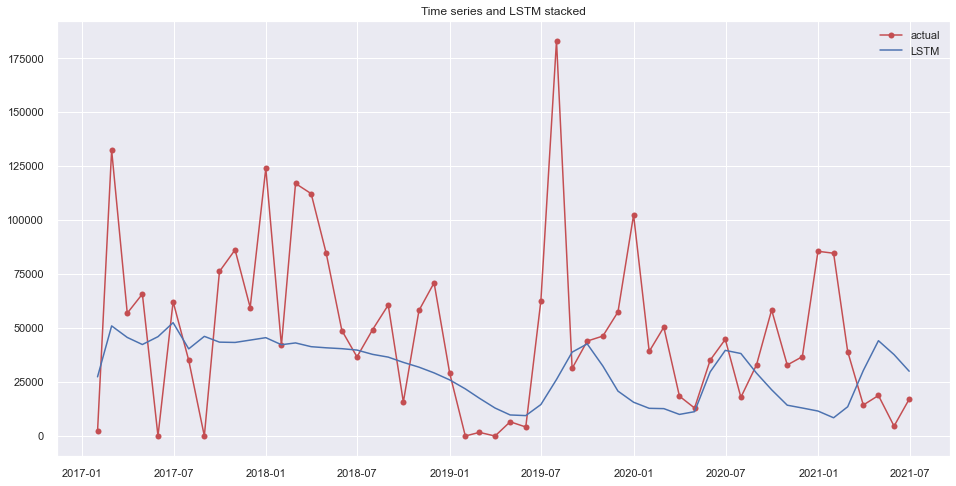

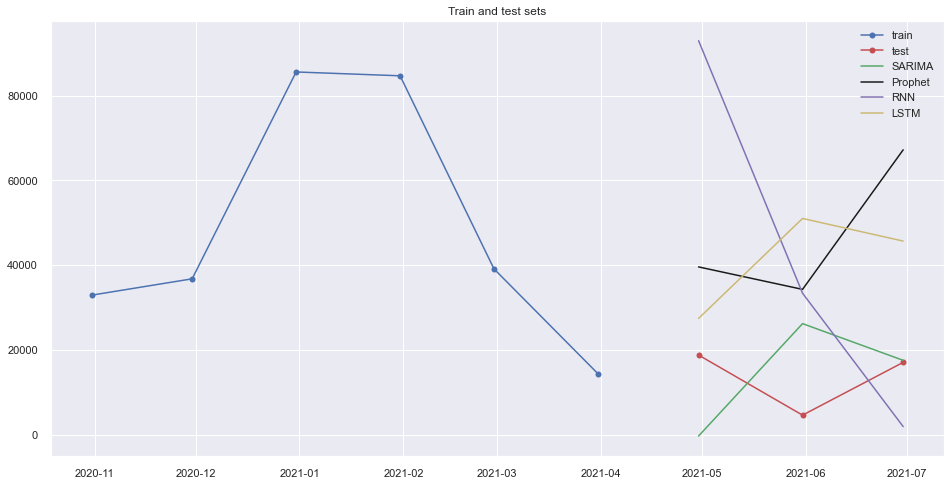

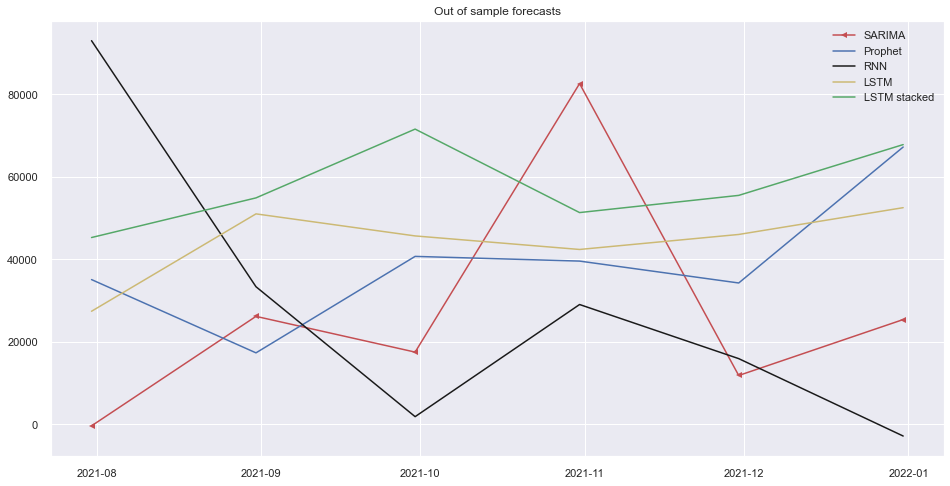

In [30]:
FIGSIZE = (16,8)

plt.figure(figsize=FIGSIZE)
plt.plot(X, y, 'o-r', label='actual')
plt.plot(X, model_arma.forecast(len(y))[1], 'x-b', label='ARMA')
plt.legend(loc = 'best')
plt.title('Time series and ARMA')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(X, y, 'o-r', label='actual')
plt.plot(X, sar.predict(start = 1, end= len(y)), 'x-b', label='SARIMA')
plt.legend(loc = 'best')
plt.title('Time series and SARIMA')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(X, y, 'o-r', label='actual')
plt.plot(forecast_prohpet.set_index('ds').loc[:, 'yhat'][:-PERIODS], 'x-b', label='Prophet')
plt.legend(loc = 'best')
plt.title('Time series and FB Prophet')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(X, y, 'o-r', label='actual')
plt.plot(X, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=len(timeseries), model=model1)), 'x-b', label='RNN')
plt.legend(loc = 'best')
plt.title('Time series and RNN')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(X, y, 'o-r', label='actual')
plt.plot(X, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=len(timeseries), model=model2)), 'x-b', label='LSTM')
plt.legend(loc = 'best')
plt.title('Time series and LSTM stacked')
plt.show()

plt.figure(figsize=FIGSIZE)
plt.plot(X_train[-TEST_SIZE * 2:], y_train[-TEST_SIZE * 2:], 'o-b', label='train')
plt.plot(X_test, y_test, 'o-r', label='test')
plt.plot(X_test, preds_sarima, 'x-g', label='SARIMA')
plt.plot(X_test, forecast_prohpet.set_index('ds').loc[future.set_index('ds').index[-TEST_SIZE:], 'yhat'], 'x-k', label='Prophet')
plt.plot(X_test, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=TEST_SIZE, model=model1)), 'x-m', label='RNN')
plt.plot(X_test, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=TEST_SIZE, model=model2)), 'x-y', label='LSTM')
plt.legend(loc = 'best')
plt.title('Train and test sets')
plt.show()
        
# Create the out-of-sample forecast time series re-using the Prophet setting
X_forecast = future.set_index('ds').index[-PERIODS:]

plt.figure(figsize=FIGSIZE)
plt.plot(X_forecast, sar.predict(start = 1, end= PERIODS), '<-r', label='SARIMA')
plt.plot(forecast_prohpet.set_index('ds').loc[future.set_index('ds').index[-PERIODS:], 'yhat'], 'b', label='Prophet')
plt.plot(X_forecast, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=PERIODS, model=model1)), 'x-k', label='RNN')
plt.plot(X_forecast, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=PERIODS, model=model2)), 'x-y', label='LSTM')
plt.plot(X_forecast, scaler.inverse_transform(DL.predict(X_test_dl_init_sc, n_steps=PERIODS, model=model3)), 'x-g', label='LSTM stacked')
plt.legend(loc = 'best')
plt.title('Out of sample forecasts')
plt.show()